In [1]:
import os
import pathlib
import shutil
import librosa
import importlib

# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.layers import Normalization, Resizing
from keras import layers
from keras import models
from IPython import display

from funcs import *

import funcs
importlib.reload(funcs)

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

audio_path = pathlib.Path('audio')
if audio_path.exists():
    shutil.rmtree(audio_path)
os.mkdir(audio_path)

2025-01-23 21:11:27.120371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
data_dir = pathlib.Path('./data')

Num GPUs Available:  1


2025-01-23 21:11:29.959166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 21:11:30.032052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 21:11:30.032790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of sumples: ', num_samples)
print('Example filename: ', filenames[0])

Number of sumples:  30000
Example filename:  tf.Tensor(b'data/30/7_30_35.wav', shape=(), dtype=string)


2025-01-23 21:11:30.147151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 21:11:30.147420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 21:11:30.147632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
train_files = filenames[:int(num_samples * 8/10)]
val_files = filenames[int(num_samples*8/10):int(num_samples * 9/10)]
test_files = filenames[int(num_samples * 9/10):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 24000
Validation set size 3000
Test set size 3000


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [6]:
# audio_max_len, audio_max = find_max_len(waveform_ds)
# print(audio_max_len)
#getAudio(waveform_ds.take(7), '1', 48)
# getAudio([(audio_max, '6')], '2', 48)

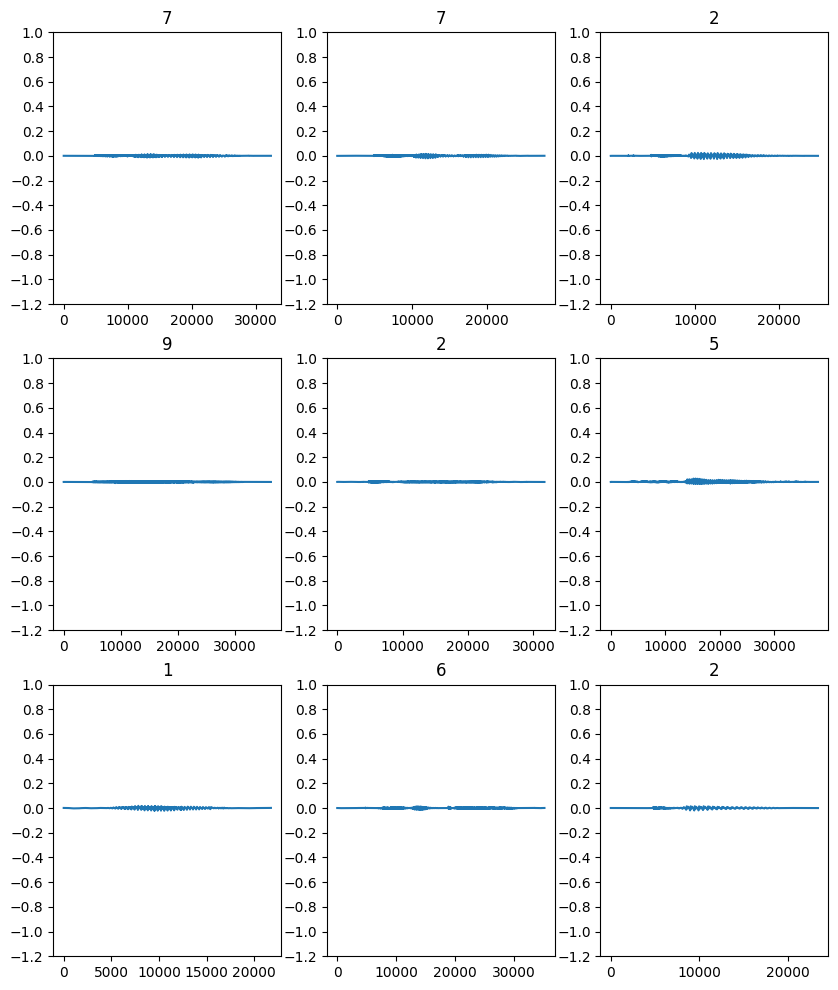

In [7]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(str(label))

plt.show()

Label: 7
Waveform shape: (32318,)
Spectrogram shape: (368, 129)
Audio playback


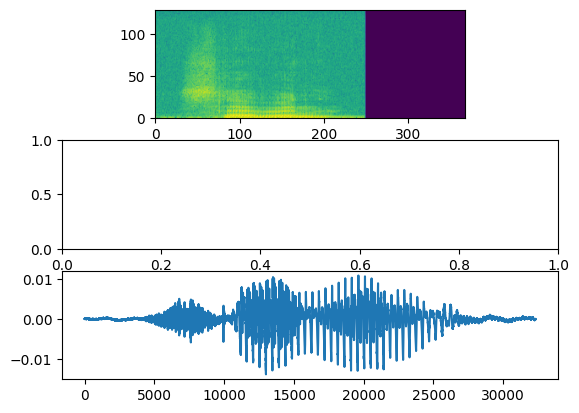

In [8]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Lib stft shape:', lib_stft.shape)
print('Audio playback')

fig, axes = plt.subplots(3, 1)
axes[0].imshow(librosa.power_to_db(spectrogram.numpy().T), origin='lower')
# axes[1].imshow(librosa.power_to_db(lib_stft), origin='lower')
axes[2].plot(waveform.numpy())
getAudio([(waveform, label)], '3', 48)

/workspaces/audio-mnist/funcs.py:83: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


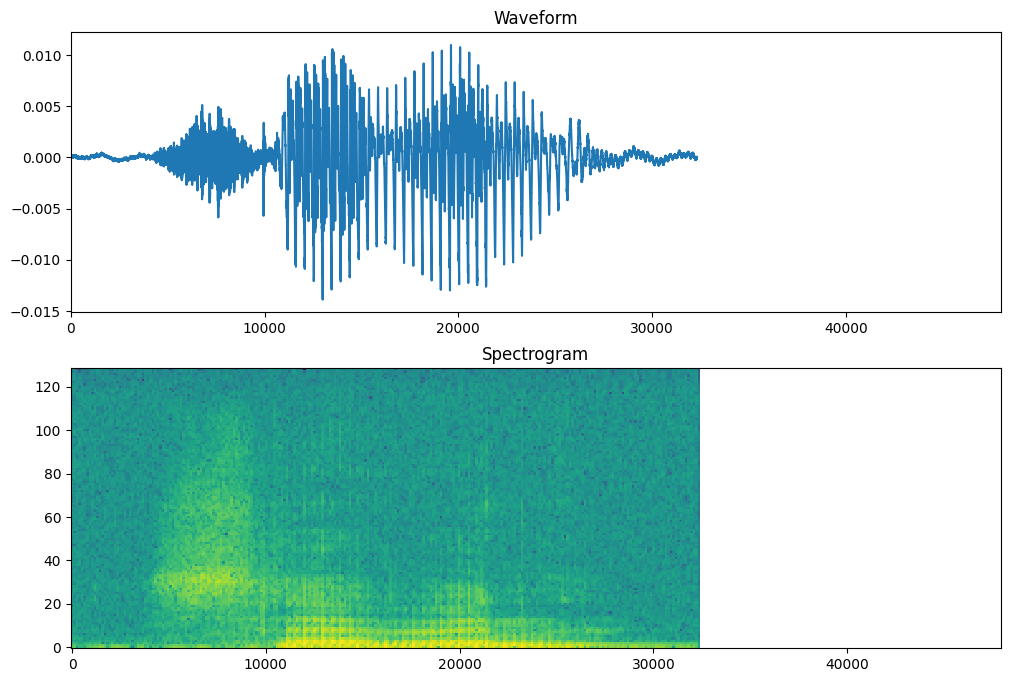

In [9]:


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

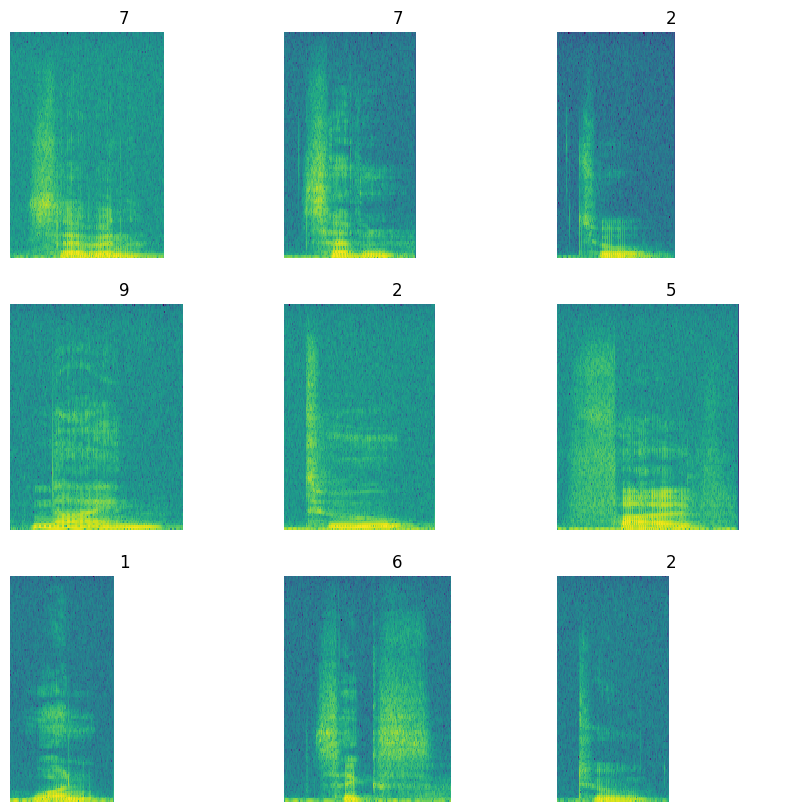

In [10]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(str(label_id.numpy()))
    ax.axis('off')

plt.show()

In [11]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [12]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [13]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = 10

norm_layer = Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (368, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2025-01-23 21:12:00.381250: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-23 21:12:00.639335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-01-23 21:12:01.313500: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4558e6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-23 21:12:01.313586: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-01-23 21:12:01.386174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-23 21:12:01.777438: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled

375/375 [==============================] - 24s 56ms/step - loss: 0.6007 - accuracy: 0.8133 - val_loss: 0.2050 - val_accuracy: 0.9393
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.2461 - accuracy: 0.9267 - val_loss: 0.1184 - val_accuracy: 0.9610
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1667 - accuracy: 0.9489 - val_loss: 0.0795 - val_accuracy: 0.9740
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1278 - accuracy: 0.9602 - val_loss: 0.0679 - val_accuracy: 0.9763
Epoch 5/10
375/375 [==============================] - 4s 11ms/step - loss: 0.1074 - accuracy: 0.9656 - val_loss: 0.0476 - val_accuracy: 0.9850
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0871 - accuracy: 0.9718 - val_loss: 0.0418 - val_accuracy: 0.9880
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0805 - accuracy: 0.9742 - val_loss: 0.0426 - val_accuracy: 0.9853
Epoch 8/10


In [16]:
# metrics = history.history
# plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.show()

In [17]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [18]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

94/94 [==============================] - 1s 6ms/step
Test set accuracy: 99%


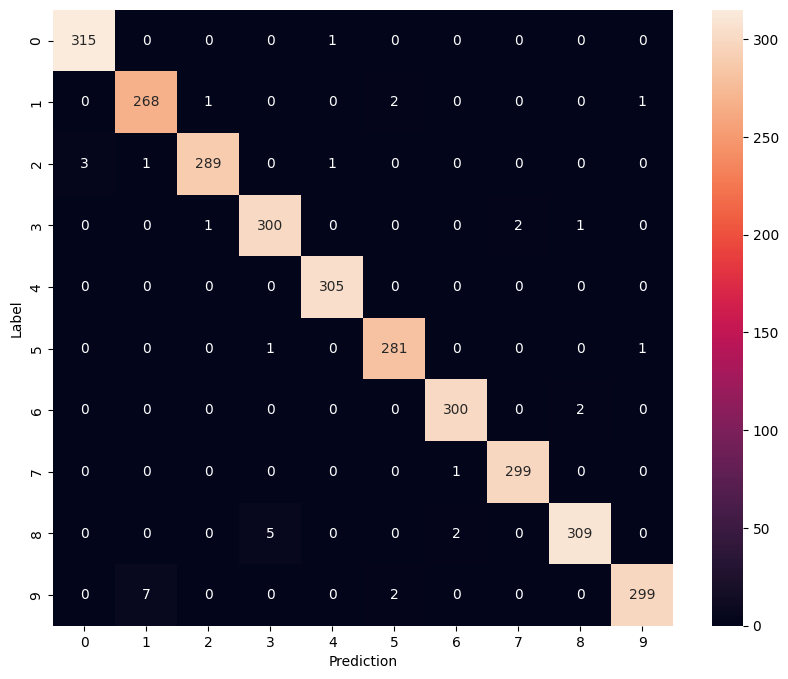

In [19]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [23]:
model.save('saved_models/digits_model.keras')
model.save_weights('saved_models/digits_model_weights.h5')